In [98]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA

In [99]:
def inhomogenous_poisson_spikes(rate_t, dt):
    """
    generate spikes probabilistically within time bins of size `dt` according to a time-dependent rate `rate_t` 
    """
    spikes = np.random.rand(*rate_t.shape) < rate_t * dt
    spikes = np.array(np.where(spikes), dtype=float).T
    spikes[:, 1] *= dt
    return spikes

# Example: spikes with 2D latent model
Here, we construct spikes for $N$ neurons from time-dependent rates $\nu_i(t)$ that are linear combinations from a latend model with $z(t)$

Specifically, we choose 
$$
   z_1(t) = sin(2\pi t) + 1\\
   z_2(t) = sin(2\pi t + \pi/2) + 1
$$

(2, 5000)


Text(0.5, 1.0, 'Latent space')

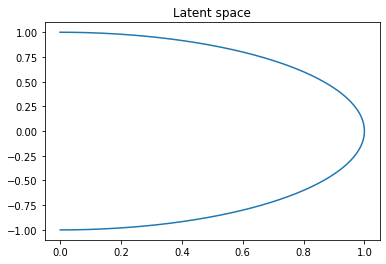

In [108]:
def z(t, omega):
    z_1 = np.sin(0.2*2*np.pi*omega*t)
    z_2 = np.cos(0.2*2*np.pi*omega*t)
    return np.vstack((z_1,z_2))

dt=0.001
T=5
ts=np.arange(0,T,dt)
zs=z(ts, 0.5)
print(zs.shape)
plt.plot(zs[0,:],zs[1,:]) 
plt.title("Latent space")

Then, we generate neural firing rates as linear combinations of the latent variables

$$
  \nu_i (t) = c_1*z_1(t) + c_2*z_2(t) + offset
$$

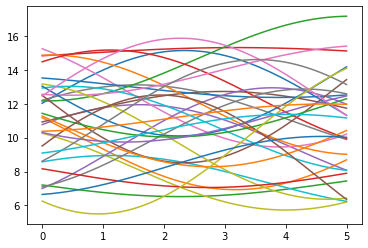

In [125]:
N = 32
mean_rate = 10
offset = mean_rate + 2*np.random.randn(N)
coefficients = 2*np.random.randn(N,2)
drate_t = np.matmul(coefficients,zs)
rate_t = offset[:, np.newaxis] + drate_t
plt.plot(ts, rate_t.T);
#plt.plot(np.mean(rates, axis=0));

[7.21909667e-01 2.28816158e-01 4.92741747e-02 6.48984757e-30
 5.21389524e-31 3.09820989e-31 8.67835276e-32 6.86115549e-33
 6.86115549e-33 6.86115549e-33 6.86115549e-33 6.86115549e-33
 6.86115549e-33 6.86115549e-33 6.86115549e-33 6.86115549e-33
 6.86115549e-33 6.86115549e-33 6.86115549e-33 6.86115549e-33
 6.86115549e-33 6.86115549e-33 6.86115549e-33 6.86115549e-33
 6.86115549e-33 6.86115549e-33 6.86115549e-33 6.86115549e-33
 6.86115549e-33 6.86115549e-33 6.86115549e-33 1.65756437e-33]
[8.85482634e+02 4.98519286e+02 2.31338705e+02 2.65494708e-12
 7.52522986e-13 5.80088209e-13 3.07013356e-13 8.63251319e-14
 8.63251319e-14 8.63251319e-14 8.63251319e-14 8.63251319e-14
 8.63251319e-14 8.63251319e-14 8.63251319e-14 8.63251319e-14
 8.63251319e-14 8.63251319e-14 8.63251319e-14 8.63251319e-14
 8.63251319e-14 8.63251319e-14 8.63251319e-14 8.63251319e-14
 8.63251319e-14 8.63251319e-14 8.63251319e-14 8.63251319e-14
 8.63251319e-14 8.63251319e-14 8.63251319e-14 4.24300771e-14]


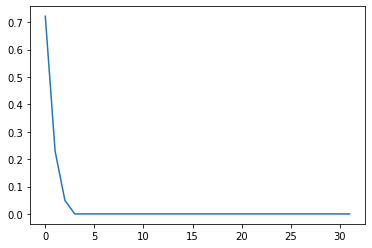

In [151]:
pca = PCA()
pca.fit(rate_t)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
plt.plot(pca.explained_variance_ratio_)

To get a bit more realistic, let's generate actual spikes as an inhomogeneous poisson process

In [127]:
spikes = inhomogenous_poisson_spikes(rate_t, dt)
print(spikes)

[[0.000e+00 9.000e-03]
 [0.000e+00 1.140e-01]
 [0.000e+00 1.180e-01]
 ...
 [3.100e+01 4.553e+00]
 [3.100e+01 4.644e+00]
 [3.100e+01 4.695e+00]]


Follow analysis of https://www.nature.com/articles/s41593-019-0555-4

Bin spikes in windows of size 30ms

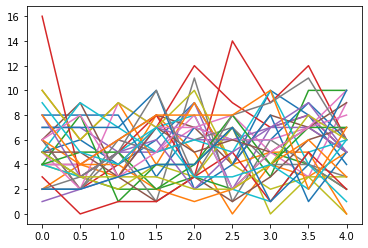

In [152]:
delta_t = 0.5 # 0.03
sd_t = 0.5    #0.05
counts, _, time = np.histogram2d(spikes[:,0], spikes[:,1],bins=[np.arange(N+1),np.arange(0,T,delta_t)])
plt.plot(time[:-1], counts.T);

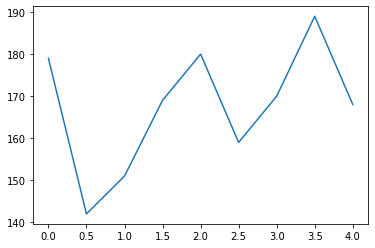

In [153]:
plt.plot(time[:-1], np.sum(counts.T, axis=1));

Now make square root transform

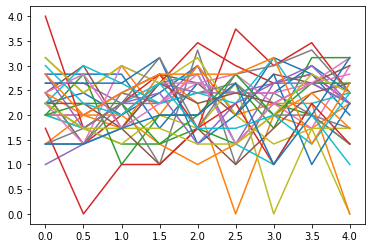

In [154]:
sqcounts = np.sqrt(counts)
plt.plot(time[:-1], sqcounts.T);

and apply Gaussian filter (with s.d. of 50ms)

(32, 9)


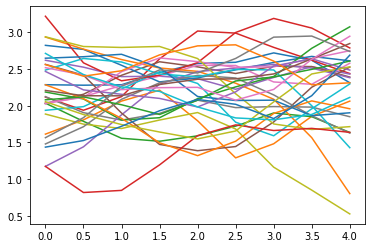

In [155]:
from scipy.ndimage import gaussian_filter1d
print(sqcounts.shape)
sd=sd_t/delta_t
signal = gaussian_filter1d(sqcounts, sigma=sd, axis=1)
plt.plot(time[:-1], signal.T);

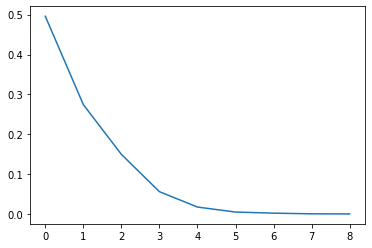

In [156]:
pca = PCA()
# print(signal.shape)
pca.fit(signal)
# print(pca.explained_variance_ratio_)
# print(pca.singular_values_)
plt.plot(pca.explained_variance_ratio_)